# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

### Цель лабораторной работы:

Изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

### Задание:

1) Выберите набор данных (датасет) для решения задачи классификации или регрессии.2) 
В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков
3) 
С использованием метода train_test_split разделите выборку на обучающую и тестову
4) .
Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метр
5) к.
Произведите подбор гиперпараметра K с использованием GridSearchCV и RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Используйте не менее двух стратегий кросс-валида
6) ии.
Сравните метрики качества исходной и оптимальной моделей.


## 1) Выберите набор данных (датасет) для решения задачи классификации или регрессии.    

### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from io import StringIO
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV



%matplotlib inline 
sns.set(style="ticks")

# скроем предупреждения о возможных ошибках для лучшей читаемости
import warnings
warnings.filterwarnings('ignore')

### Смотрим на датасет

In [2]:
data = pd.read_csv('./diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [3]:
df = data.sample(n=2000)

In [4]:
df['Diabetes_binary'].value_counts()

Diabetes_binary
1.0    1010
0.0     990
Name: count, dtype: int64

In [5]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
14658,0.0,0.0,1.0,1.0,31.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,5.0,2.0,0.0,0.0,6.0,6.0,8.0
7097,0.0,1.0,1.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,5.0,0.0,30.0,0.0,1.0,9.0,4.0,5.0
43912,1.0,1.0,1.0,1.0,31.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,0.0,30.0,1.0,1.0,12.0,4.0,3.0
65633,1.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,4.0,0.0,1.0,10.0,4.0,5.0
43226,1.0,1.0,1.0,1.0,35.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,10.0,0.0,0.0,0.0,9.0,6.0,8.0


In [6]:
df.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.5050,0.565000,0.527000,0.971500,29.983000,0.4680,0.055500,0.164500,0.696000,0.610500,...,0.942500,0.096000,2.877000,3.867500,5.787000,0.257000,0.445500,8.586500,4.889500,5.636000
std,0.5001,0.495881,0.499395,0.166438,7.031176,0.4991,0.229011,0.370821,0.460098,0.487759,...,0.232854,0.294665,1.108822,8.439168,10.054958,0.437089,0.497145,2.872567,1.050639,2.177814
min,0.0000,0.000000,0.000000,0.000000,15.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.0000,0.000000,0.000000,1.000000,25.000000,0.0000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,1.0000,1.000000,1.000000,1.000000,29.000000,0.0000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.0000,1.000000,1.000000,1.000000,33.000000,1.0000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,5.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.0000,1.000000,1.000000,1.000000,81.000000,1.0000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [7]:
print("Размер набора:")
print(f'В датасете {df.shape[0]} строк и {df.shape[1]} колонок.')

Размер набора:
В датасете 2000 строк и 22 колонок.


In [8]:
df.dtypes

Diabetes_binary         float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object

In [9]:
df = df.astype('int')
df.dtypes

Diabetes_binary         int32
HighBP                  int32
HighChol                int32
CholCheck               int32
BMI                     int32
Smoker                  int32
Stroke                  int32
HeartDiseaseorAttack    int32
PhysActivity            int32
Fruits                  int32
Veggies                 int32
HvyAlcoholConsump       int32
AnyHealthcare           int32
NoDocbcCost             int32
GenHlth                 int32
MentHlth                int32
PhysHlth                int32
DiffWalk                int32
Sex                     int32
Age                     int32
Education               int32
Income                  int32
dtype: object

## 3) С использованием метода train_test_split разделите выборку на обучающую и тестовую.

In [10]:
X = df.drop('Diabetes_binary', axis=1)
Y = df['Diabetes_binary']

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(1400, 21), (600, 21)
(1400,), (600,)


In [12]:
KNC = KNeighborsClassifier(n_neighbors=5)
KNC.fit(X_train, Y_train)

KNeighborsClassifier()

In [13]:
My_KNN_target_1_0 = KNC.predict(X_train)
My_KNN_Y_Pred = KNC.predict(X_test)
print('Accuracy:',accuracy_score(Y_train,My_KNN_target_1_0), accuracy_score(Y_test,My_KNN_Y_Pred))
print('Precision:',precision_score(Y_train,My_KNN_target_1_0), precision_score(Y_test,My_KNN_Y_Pred))
print('F1:',f1_score(Y_train,My_KNN_target_1_0), f1_score(Y_test,My_KNN_Y_Pred))
print('Recall:',recall_score(Y_train,My_KNN_target_1_0), recall_score(Y_test,My_KNN_Y_Pred))

Accuracy: 0.76 0.6866666666666666
Precision: 0.7453083109919572 0.7040816326530612
F1: 0.7679558011049724 0.6877076411960132
Recall: 0.792022792022792 0.672077922077922


In [14]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), X, Y, cv=4, scoring='accuracy')
scores

array([0.656, 0.6  , 0.566, 0.634])

In [15]:
np.mean(scores)

0.614

In [16]:
KN_range_list = list(range(0,150,1))
KN_range_list[0] = 1

In [17]:
second_grid = GridSearchCV(KNeighborsClassifier(),param_grid = [{'n_neighbors':KN_range_list}], scoring = 'accuracy',cv=5, return_train_score=True)
print(second_grid)
therd_grid=RandomizedSearchCV(KNeighborsClassifier(),param_distributions = [{'n_neighbors':KN_range_list}], scoring = 'accuracy',cv=5, return_train_score=True)
print(therd_grid)
second_grid.fit(X_train, Y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12, 13, 14, 15, 16, 17, 18, 19, 20,
                                          21, 22, 23, 24, 25, 26, 27, 28, 29, ...]}],
             return_train_score=True, scoring='accuracy')
RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': [1, 1, 2, 3, 4, 5, 6, 7,
                                                         8, 9, 10, 11, 12, 13,
                                                         14, 15, 16, 17, 18, 19,
                                                         20, 21, 22, 23, 24, 25,
                                                         26, 27, 28, 29, ...]}],
                   return_train_score=True, scoring='accuracy')


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                          12, 13, 14, 15, 16, 17, 18, 19, 20,
                                          21, 22, 23, 24, 25, 26, 27, 28, 29, ...]}],
             return_train_score=True, scoring='accuracy')

In [18]:
therd_grid.fit(X_train, Y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions=[{'n_neighbors': [1, 1, 2, 3, 4, 5, 6, 7,
                                                         8, 9, 10, 11, 12, 13,
                                                         14, 15, 16, 17, 18, 19,
                                                         20, 21, 22, 23, 24, 25,
                                                         26, 27, 28, 29, ...]}],
                   return_train_score=True, scoring='accuracy')

In [19]:
second_grid.best_params_


{'n_neighbors': 29}

In [20]:
therd_grid.best_params_

{'n_neighbors': 32}

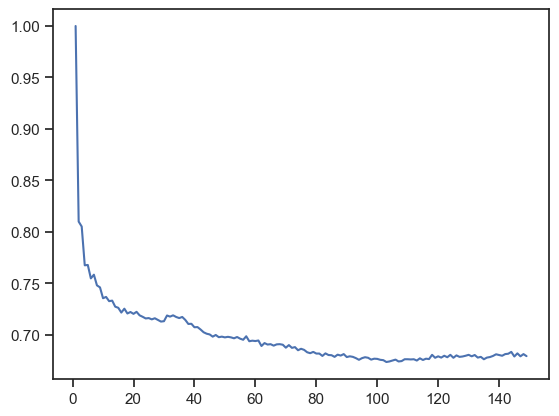

In [21]:
plt.plot(KN_range_list, second_grid.cv_results_["mean_train_score"]);

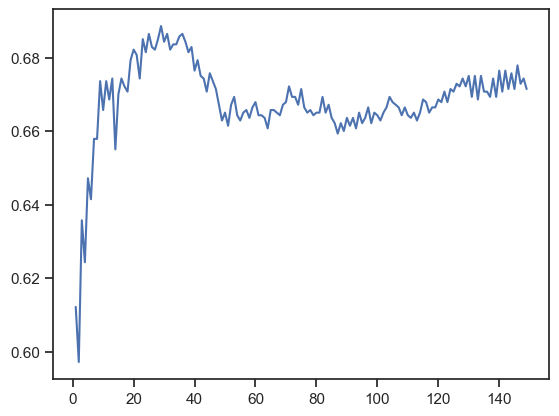

In [23]:


plt.plot(KN_range_list, second_grid.cv_results_["mean_test_score"]);


Accuracy: 0.6728571428571428 0.7133333333333334
Precision: 0.6675824175824175 0.7297297297297297
Recall: 0.6923076923076923 0.7012987012987013
F1: 0.6797202797202797 0.7152317880794702


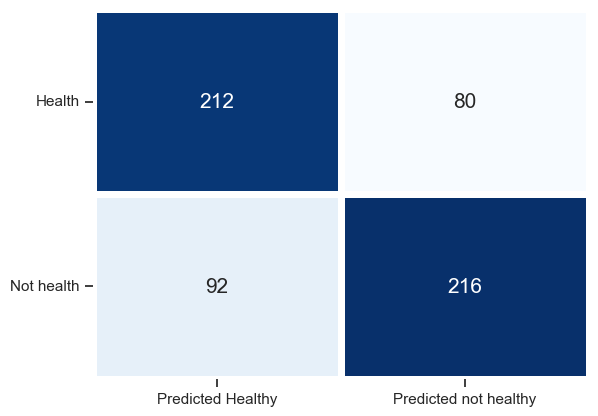

In [24]:
KNN_Searched = KNeighborsClassifier(n_neighbors=134)
KNN_Searched.fit(X_train, Y_train)
KNN_Searched_target_1 = KNN_Searched.predict(X_train)
Y_KNN_Searched_Pred= KNN_Searched.predict(X_test)

print(f'Accuracy:',accuracy_score(Y_train,KNN_Searched_target_1),accuracy_score(Y_test,Y_KNN_Searched_Pred))
print(f'Precision:',precision_score(Y_train,KNN_Searched_target_1),precision_score(Y_test, Y_KNN_Searched_Pred))
print(f'Recall:',recall_score(Y_train,KNN_Searched_target_1),recall_score(Y_test,Y_KNN_Searched_Pred))
print(f'F1:',f1_score(Y_train,KNN_Searched_target_1),f1_score(Y_test,Y_KNN_Searched_Pred))
cm = confusion_matrix(Y_test, Y_KNN_Searched_Pred)
sns.heatmap(cm,cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15},
    yticklabels = ['Health', 'Not health'], xticklabels = ['Predicted Healthy', 'Predicted not healthy'])
plt.yticks(rotation = 0)
plt.show()